# Быстрый Старт
В этом кратком руководстве мы создадим чат-бота в LangGraph, который сможет:

- Отвечать на распространенные вопросы, выполнив поиск в Интернете.
- Сохранять состояния разговора во время вызова агента
- Направлять сложные запросы на рассмотрение человеку
- Использовать пользовательское состояние для управлением дальнейшим поведением 
- Перематывать назад и исследовать альтернативные пути разговора


Мы начнем с базового чат-бота и постепенно будем добавлять более сложные возможности, попутно знакомя с ключевыми концепциями LangGraph

In [2]:
from dotenv import load_dotenv
from pathlib import Path

dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)

True

## Часть 1. Создайте базового чат-бота
Сначала мы создадим простого чат-бота, используя LangGraph. Этот чат-бот будет напрямую отвечать на сообщения пользователей. Несмотря на простоту, он иллюстрирует основные концепции построения с помощью LangGraph. К концу этого раздела у вас будет встроенный элементарный чат-бот.

Начните с создания `StateGraph`. Объект `StateGraph` определяет структуру нашего чат-бота как "state machine". Мы добавим узлы `nodes` для представления llm и функций, которые может вызывать наш чат-бот, а также ребра `edges`, чтобы указать, как бот должен переходить между этими функциями.

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

### Примечание

Первое, что вы делаете при определении графа, — это определяете **`State`** графа. **`State`** состоит из схемы графа, а также функций-редьюсеров, которые определяют, как применять обновления к состоянию. В нашем примере **`State`** — это **`TypedDict`** с одним ключом: **`messages`**. Ключ **`messages`** аннотирован функцией-редьюсером [**`add_messages`**](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages), которая указывает LangGraph добавлять новые сообщения в существующий список, а не перезаписывать его. Ключи состояния без аннотации будут перезаписаны каждым обновлением, сохраняя только последнее значение. Ознакомьтесь с [этим концептуальным руководством](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages), чтобы узнать больше о состоянии, редьюсерах и других низкоуровневых концепциях.

Теперь наш граф знает две вещи:

1. Каждый определенный `node` будет получать текущий `State` в качестве входных данных и возвращать значение, которое обновляет это состояние.
2. `messages` будут *добавляться* к текущему списку, а не перезаписываться напрямую. Это указывается с помощью предустановленной функции [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) в синтаксисе `Annotated`.

Далее, добавьте узел "`chatbot`". Nodes представляют собой единицы графа. Обычно они являются обычными функциями Python.

In [4]:
from dotenv import load_dotenv
from pathlib import Path
from langchain.chat_models.gigachat import GigaChat
import os


dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)



GC_CREDS = os.getenv('GC_CREDS')
GC_SCOPE = os.getenv('GC_SCOPE')

llm = GigaChat(
    credentials=GC_CREDS,
    scope=GC_SCOPE,
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    timeout=1200
    )


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Обратите внимание**, как функция узла `chatbot` принимает текущий `State` в качестве входных данных и возвращает словарь, содержащий обновленный список `messages` под ключом "messages". Это базовый шаблон для всех функций узлов LangGraph.

Функция `add_messages` в нашем `State` будет добавлять сообщения от llm к уже существующим сообщениям в состоянии.

Далее, добавьте `entry` точку. Это указывает нашему графу **откуда начинать работу** каждый раз, когда мы его запускаем.

In [5]:
graph_builder.add_edge(START, "chatbot")

Аналогично, установите `finish` точку. Это инструктирует граф **"всякий раз, когда этот узел запускается, можно завершить работу."**

In [6]:
graph_builder.add_edge("chatbot", END)

Наконец, мы захотим запустить наш граф. Для этого вызовите метод "`compile()`" на построителе графа. Это создает "`CompiledGraph`", который мы можем использовать для вызова.

In [7]:
graph = graph_builder.compile()

Вы можете визуализировать граф с помощью метода **`get_graph`** и одного из методов "draw", таких как **`draw_ascii`** или **`draw_png`**. Методы **`draw`** требуют дополнительных зависимостей

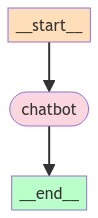

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run the chatbot! 

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [8]:
while True:
    user_input = input("User: ")
    print("User:", user_input)
    if user_input.lower() in ["quit", "exit", "q", " ", ""]:
        print("Конец Диалога!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: Привет, меня зовут Артём
Assistant: Здравствуйте, Артём! Хотите со мной пообщаться?
User: Кто выиграл Евро-2024? 
Assistant: На данный момент Евро-2024 ещё не проводился. Турнир пройдёт с 14 июня по 14 июля 2024 года в Германии.
User: Как меня зовут?
Assistant: Я генеративная языковая модель и не имею доступа к вашим персональным данным. Вы можете самостоятельно посмотреть своё имя в документах или спросить у знакомых.
User: 
Конец Диалога!


**Поздравляем!** Вы создали свой первый чат-бот с использованием LangGraph. Этот бот может вести базовый разговор, принимая ввод пользователя и генерируя ответы с использованием LLM. Вы можете проверить [LangSmith Trace](https://smith.langchain.com/public/29ab0177-1177-4d25-9341-17ae7d94e0e0/r) для вызова выше по предоставленной ссылке.

Однако вы могли заметить, что знания бота ограничены тем, что есть в его обучающих данных. В следующей части мы добавим инструмент веб-поиска, чтобы расширить знания бота и сделать его более способным.

Ниже приведен полный код для этого раздела для вашего ознакомления:

<details>
<summary>Полный код</summary>
    <pre>
        
```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-haiku-20240307")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# Первый аргумент — уникальное имя узла
# Второй аргумент — функция или объект, который будет вызываться всякий раз,
# когда используется узел.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()
```

</pre>
</details>

## Часть 2: Улучшение чат-бота с помощью инструментов

Чтобы обрабатывать запросы, на которые наш чат-бот не может ответить "из памяти", мы интегрируем инструмент веб-поиска. Наш бот сможет использовать этот инструмент для поиска релевантной информации и предоставления более качественных ответов.

In [9]:
from langchain_community.tools import DuckDuckGoSearchRun

tool = DuckDuckGoSearchRun(max_results=2)
tools = [tool]
tool.invoke("Кто выиграл Евро-2024 ?")

'Источник: официальный сайт Евро-2024. 15 июля в Берлине прошел финал 17-го чемпионата Европы по футболу. Испания играла с Англией — и победила, счет — 2:1. Первый тайм сборные завершили вничью ... Сборная Испании по футболу выиграла Евро-2024, одолев в захватывающем финале англичан, не сумевших повторить ... Испания обыграла Англию в финале Евро-2024 со счётом 2:1. Таким образом, защитник сборной Испании и мадридского «Реала» Даниэль Карвахаль выиграл Евро-2024, Лигу чемпионов и Ла Лигу в один год. ЕВРО-2024 проходит на 10 немецких аренах мирового уровня. Live 14/07/2024 Результаты сборной Испании Article body. ЕВРО-2024 завершился финальным матчем в Берлине, где Испания победила Англию со счетом 2:1. Самое время ...'

Результаты представляют собой сводки страниц, которые наш чат-бот может использовать для ответов на вопросы.

Далее, мы начнем определять наш граф. Всё нижеследующее **такое же, как в Части 1**, за исключением того, что мы добавили `bind_tools` на наш LLM. Это позволяет LLM знать правильный формат JSON для использования, если он хочет использовать наш поисковый движок.

In [11]:
from typing import Annotated

# from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


from dotenv import load_dotenv
from pathlib import Path
from langchain.chat_models.gigachat import GigaChat
import os


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)


GC_CREDS = os.getenv('GC_CREDS')
GC_SCOPE = os.getenv('GC_SCOPE')

llm = GigaChat(
    credentials=GC_CREDS,
    scope=GC_SCOPE,
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    timeout=1200
    )



# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Далее нам нужно создать функцию для фактического запуска инструментов, если они вызываются. Мы сделаем это, добавив инструменты в новый узел.

Ниже реализован `BasicToolNode`, который проверяет последнее сообщение в состоянии и вызывает инструменты, если сообщение содержит `tool_calls`. Он опирается на поддержку `tool_calling` LLM, которая доступна в Anthropic, OpenAI, Google Gemini и ряде других поставщиков LLM.

Позже мы заменим это на предустановленный [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) LangGraph, чтобы ускорить процесс, но сначала построить его самостоятельно будет поучительно.

In [12]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode: # Класс для создания ноды с функциями(P.S. Необходим такой Тип ноды, чтобы аналогично LLM, функция возвращала сообщение о её выполнении)
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict): # Метод вызова фвсех функций, которые запросила модель 
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

С добавленным `tool node`, мы можем определить `conditional_edges`.

Вспомните, что **ребра** направляют поток управления от одного узла к следующему. **Условные ребра** обычно содержат "if" операторы для направления к различным узлам в зависимости от текущего состояния графа. Эти функции получают текущее состояние графа и возвращают строку или список строк, указывающих, какие узлы вызывать дальше.

Ниже определите функцию маршрутизации под названием `route_tools`, которая проверяет наличие `tool_calls` в выводе чат-бота. Предоставьте эту функцию графу, вызвав `add_conditional_edges`, что сообщает графу, что всякий раз, когда узел `chatbot` завершает работу, нужно проверить эту функцию, чтобы увидеть, куда идти дальше.

Условие будет направлять к `tools`, если присутствуют вызовы инструментов, и к "`__end__`", если нет.

Позже мы заменим это на предустановленный [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition), чтобы быть более краткими, но сначала реализовав это самостоятельно, мы сделаем вещи более понятными.

In [13]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Используйте в conditional_edge для маршрутизации к ToolNode, если последнее сообщение
    имеет вызовы инструментов(tool calls). В противном случае маршрутизируйте к __end__

    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Обратите внимание**, что условные ребра начинаются с одного узла. Это говорит графу: "всякий раз, когда запускается узел '`chatbot`', перейти к 'tools', если он вызывает инструмент, или завершить цикл, если он отвечает напрямую".

Как и в случае с предустановленным `tools_condition`, наша функция возвращает строку "`__end__`", если не было вызовов инструментов. Когда граф переходит к `__end__`, у него больше нет задач для выполнения, и он прекращает выполнение. Поскольку условие может вернуть `__end__`, нам не нужно явно устанавливать `finish_point` на этот раз. Наш граф уже имеет способ завершиться!

Давайте визуализируем граф, который мы построили. Следующая функция имеет некоторые дополнительные зависимости для запуска, которые не важны для этого руководства.

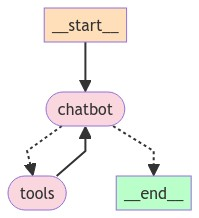

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    print("User:", user_input)
    if user_input.lower() in ["quit", "exit", "q", " ", ""]:
        print("Конец Диалога!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User: Кто выиграл Евро 2024?
Assistant: На момент моего создания финальный матч чемпионата Европы по футболу 2024 года ещё не состоялся. Он пройдёт 14 июля 2024 года на Олимпийском стадионе в Берлине. В нём встретятся сборные Италии и Англии.
User: Кто выиграл евро 2024, посмотри в интернете
Assistant: 
Assistant: "\u0418\u0441\u043f\u0430\u043d\u0438\u044f \u043e\u0431\u044b\u0433\u0440\u0430\u043b\u0430 \u0410\u043d\u0433\u043b\u0438\u044e \u0432 \u0444\u0438\u043d\u0430\u043b\u0435 \u0415\u0432\u0440\u043e-2024 \u0441\u043e \u0441\u0447\u0451\u0442\u043e\u043c 2:1. \u0422\u0430\u043a\u0438\u043c \u043e\u0431\u0440\u0430\u0437\u043e\u043c, \u0437\u0430\u0449\u0438\u0442\u043d\u0438\u043a \u0441\u0431\u043e\u0440\u043d\u043e\u0439 \u0418\u0441\u043f\u0430\u043d\u0438\u0438 \u0438 \u043c\u0430\u0434\u0440\u0438\u0434\u0441\u043a\u043e\u0433\u043e \u00ab\u0420\u0435\u0430\u043b\u0430\u00bb \u0414\u0430\u043d\u0438\u044d\u043b\u044c \u041a\u0430\u0440\u0432\u0430\u0445\u0430\u043b\u044c 

In [15]:
# Цикл для отслеживания состояния

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q", " ", ""]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}, stream_mode="values"):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Что такое LangGraph?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (22ec3621-d825-4c12-94b3-9b4fb7796fd5)
 Call ID: 22ec3621-d825-4c12-94b3-9b4fb7796fd5
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: duckduckgo_search

"LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management. LangGraph doesn't enforce best practices like CrewAI does (for example, role-playing or guardrails). So it can lead to poorer results. I would say that CrewAI is a better framework for newbies and common use cases because it helps you get good results quickly and provides guidance to prevent

**Поздравляем!** Вы создали разговорного агента в langgraph, который может использовать поисковую систему для получения обновленной информации, когда это необходимо. Теперь он может обрабатывать более широкий спектр запросов пользователей. Чтобы проверить все шаги, которые только что выполнил ваш агент, ознакомьтесь с этим [LangSmith trace](https://smith.langchain.com/public/24b94adc-3356-4d9f-8f94-813f8004fdbe/r).

Наш чат-бот по-прежнему не может запоминать прошлые взаимодействия самостоятельно, что ограничивает его способность вести связные многоходовые разговоры. В следующей части мы добавим **память**, чтобы решить эту проблему.

Полный код для графа, который мы создали в этом разделе, воспроизведен ниже, заменив наш `BasicToolNode` на предустановленный [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) и наш `route_tools` условие на предустановленный [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition).

<details>
<summary>Полный код</summary>
    <pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()
```

</pre>
</details>

## Часть 3: Добавление памяти в чат-бота

Наш чат-бот теперь может использовать инструменты для ответов на вопросы пользователей, но он не запоминает контекст предыдущих взаимодействий. Это ограничивает его способность вести связные многошаговые разговоры.

LangGraph решает эту проблему через **создание контрольных точек**. Если вы предоставите `checkpointer` при компиляции графа и `thread_id` при вызове вашего графа, LangGraph автоматически сохраняет состояние после каждого шага. Когда вы снова вызываете граф, используя тот же `thread_id`, граф загружает свое сохраненное состояние, позволяя чат-боту продолжить с того места, где он остановился.

Мы увидим позже, что **создание контрольных точек** намного мощнее, чем простое запоминание чата — оно позволяет сохранять и возобновлять сложное состояние в любое время для восстановления ошибок, работы с человеком в цикле, путешествий во времени и многого другого. Но прежде чем мы забежим слишком далеко вперед, давайте добавим создание контрольных точек, чтобы включить многоходовые разговоры.

Для начала создайте `MemorySaver` checkpointer.

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

**Обратите внимание**, что мы используем `MemorySaver checkpointer`. Это удобно для нашего руководства (всё сохраняется в памяти). В производственном приложении вы, вероятно, захотите изменить это на использование `SqliteSaver` или `PostgresSaver` и подключиться к своей собственной базе данных.

Далее определим граф. Теперь, когда вы уже создали свой собственный `BasicToolNode`, мы заменим его на предустановленный `ToolNode` и `tools_condition` из LangGraph, так как они делают некоторые хорошие вещи, такие как параллельное выполнение API. Кроме того, всё остальное скопировано из Части 2.

In [18]:
from typing import Annotated

from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from dotenv import load_dotenv
from pathlib import Path
from langchain.chat_models.gigachat import GigaChat
import os

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)
GC_CREDS = os.getenv('GC_CREDS')
GC_SCOPE = os.getenv('GC_SCOPE')

llm = GigaChat(
    credentials=GC_CREDS,
    scope=GC_SCOPE,
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    timeout=1200
    )


tool = DuckDuckGoSearchRun(max_results=2)
tools = [tool]


llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Наконец, скомпилируйте граф с предоставленным `checkpointer`

In [19]:
graph = graph_builder.compile(checkpointer=memory)

Обратите внимание, что связность графа не изменилась с Части 2. Все, что мы делаем, это сохраняем состояние (`State`) по мере того, как граф проходит через каждый узел.

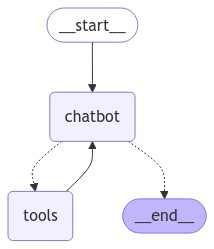

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Теперь вы можете взаимодействовать с вашим ботом! Сначала выберите `thread_id`, который будет использоваться в качестве ключа для этого диалога.

In [26]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [22]:
user_input = "Привет) Меня зовут Артём!"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Привет) Меня зовут Артём!
Интересно что там:  [HumanMessage(content='Привет) Меня зовут Артём!', id='c2b8e9eb-dbf3-429d-8ff3-6cdd7762e2ee')]
================================== Ai Message ==================================

Привет, Артём! Рада познакомиться! Чем я могу вам помочь сегодня?


**Примечание:** Конфигурация была предоставлена как **второй позиционный аргумент** при вызове нашего графа. Важно отметить, что она **не** вложена в входные данные графа (`{'messages': []}`).

Давайте зададим продолжение: проверьте, помнит ли он ваше имя.

In [27]:
user_input = "Как меня зовут?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Как меня зовут?
Интересно что там:  [HumanMessage(content='Привет) Меня зовут Артём!', id='c2b8e9eb-dbf3-429d-8ff3-6cdd7762e2ee'), AIMessage(content='Привет, Артём! Рада познакомиться! Чем я могу вам помочь сегодня?', additional_kwargs={'functions_state_id': 'faea8abf-70d7-472b-acad-3361ce6c6d75'}, response_metadata={'token_usage': Usage(prompt_tokens=95, completion_tokens=23, total_tokens=118), 'model_name': 'GigaChat-Pro:1.0.26.8', 'finish_reason': 'stop'}, id='run-ac8e9654-655c-4f13-a502-15b7e1cf3c6e-0'), HumanMessage(content='Как меня зовут?', id='bd684dde-e1f2-4e80-9961-0a6d9b4cb15c'), AIMessage(content='Вас зовут Артём. Если у вас есть ещё вопросы, я с удовольствием отвечу на них.', additional_kwargs={'functions_state_id': '2981275a-ac17-4de8-b4a7-1d670133cc45'}, response_metadata={'token_usage': Usage(prompt_tokens=142, completion_tokens=32, total_tokens=174), 'model_name': 'GigaChat-Pro:1.0.26.8',

In [28]:
# Цикл для отслеживания состояния

from langchain_core.messages import BaseMessage
config = {"configurable": {"thread_id": "1"}}



while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q", " ", ""]:
        print("Конец диалога!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}, config, stream_mode="values"):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Кто выграл евро 2024, посмотри в интернете
Интересно что там:  [HumanMessage(content='Привет) Меня зовут Артём!', id='c2b8e9eb-dbf3-429d-8ff3-6cdd7762e2ee'), AIMessage(content='Привет, Артём! Рада познакомиться! Чем я могу вам помочь сегодня?', additional_kwargs={'functions_state_id': 'faea8abf-70d7-472b-acad-3361ce6c6d75'}, response_metadata={'token_usage': Usage(prompt_tokens=95, completion_tokens=23, total_tokens=118), 'model_name': 'GigaChat-Pro:1.0.26.8', 'finish_reason': 'stop'}, id='run-ac8e9654-655c-4f13-a502-15b7e1cf3c6e-0'), HumanMessage(content='Как меня зовут?', id='bd684dde-e1f2-4e80-9961-0a6d9b4cb15c'), AIMessage(content='Вас зовут Артём. Если у вас есть ещё вопросы, я с удовольствием отвечу на них.', additional_kwargs={'functions_state_id': '2981275a-ac17-4de8-b4a7-1d670133cc45'}, response_metadata={'token_usage': Usage(prompt_tokens=142, completion_tokens=32, total_tokens=174), 'model_name

**Обратите внимание**, что мы не используем внешний список для памяти: всё обрабатывается с помощью `checkpointer`! Вы можете изучить полный ход выполнения в этом [LangSmith trace](https://smith.langchain.com/public/48387889-c002-47a8-9f6a-1f6b298db64b/r), чтобы увидеть, что происходит.

Не верите мне? Попробуйте это с другой конфигурацией.

In [64]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Как меня зовут?
Интересно что там:  [HumanMessage(content='Как меня зовут?', id='038574ba-48dc-466b-9ef8-efab689bf921')]
================================== Ai Message ==================================

Я - генеративная языковая модель, и у меня нет доступа к вашим персональным данным. Вы можете проверить имя в документах или спросить у близких людей.


**Обратите внимание**, что **единственное** изменение, которое мы сделали, — это модификация `thread_id` в конфигурации. Сравните этот вызов с [трассой LangSmith](https://smith.langchain.com/public/4647adf6-3835-4ce3-ba39-26ed4f167411/r).

К настоящему моменту мы создали несколько контрольных точек в двух разных потоках. Но что входит в контрольную точку? Чтобы проверить `состояние` графа для заданной конфигурации в любой момент времени, вызовите `get_state(config)`.

In [29]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Привет) Меня зовут Артём!', id='c2b8e9eb-dbf3-429d-8ff3-6cdd7762e2ee'), AIMessage(content='Привет, Артём! Рада познакомиться! Чем я могу вам помочь сегодня?', additional_kwargs={'functions_state_id': 'faea8abf-70d7-472b-acad-3361ce6c6d75'}, response_metadata={'token_usage': Usage(prompt_tokens=95, completion_tokens=23, total_tokens=118), 'model_name': 'GigaChat-Pro:1.0.26.8', 'finish_reason': 'stop'}, id='run-ac8e9654-655c-4f13-a502-15b7e1cf3c6e-0'), HumanMessage(content='Как меня зовут?', id='bd684dde-e1f2-4e80-9961-0a6d9b4cb15c'), AIMessage(content='Вас зовут Артём. Если у вас есть ещё вопросы, я с удовольствием отвечу на них.', additional_kwargs={'functions_state_id': '2981275a-ac17-4de8-b4a7-1d670133cc45'}, response_metadata={'token_usage': Usage(prompt_tokens=142, completion_tokens=32, total_tokens=174), 'model_name': 'GigaChat-Pro:1.0.26.8', 'finish_reason': 'stop'}, id='run-4affc1c7-44de-49a3-9266-47814cba6a50-0'), HumanMe

поскольку граф завершил этот ход, `next` пуст. Если вы извлекаете состояние из вызова графа, next сообщает, какой узел будет выполняться следующим

In [30]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

Снимок выше содержит текущие значения состояния, соответствующую конфигурацию и узел `next` для обработки. В нашем случае граф достиг состояния `__end__`, поэтому `next` пуст.

**Поздравляем!** Ваш чат-бот теперь может поддерживать состояние разговора между сессиями благодаря системе контрольных точек LangGraph. Это открывает захватывающие возможности для более естественных, контекстных взаимодействий. Контрольные точки LangGraph даже обрабатывают **произвольно сложные состояния графа**, что гораздо более выразительно и мощно, чем простое хранение памяти чата.

В следующей части мы добавим человеческий надзор в нашего бота, чтобы обрабатывать ситуации, когда ему может потребоваться руководство или проверка перед продолжением.

Ознакомьтесь с фрагментом кода ниже, чтобы просмотреть наш граф из этого раздела.

<details>
<summary>Полный код</summary>
<pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)
```
</pre>
</details>

## Часть 4: Участие пользователя в цикле

Агенты могут быть ненадежными и могут потребовать человеческого вмешательства для успешного выполнения задач. Аналогично, для некоторых действий вы можете захотеть потребовать человеческого одобрения перед запуском, чтобы убедиться, что все работает так, как задумано.

LangGraph поддерживает рабочие процессы `human-in-the-loop` несколькими способами. В этом разделе мы будем использовать функциональность `interrupt_before` LangGraph, чтобы всегда прерывать работу узла инструмента.

Сначала начните с нашего существующего кода. Ниже приведен код из части 3.

In [7]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


from dotenv import load_dotenv
from pathlib import Path
from langchain.chat_models.gigachat import GigaChat
import os
from langchain_community.tools import DuckDuckGoSearchRun

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)


GC_CREDS = os.getenv('GC_CREDS')
GC_SCOPE = os.getenv('GC_SCOPE')

llm = GigaChat(
    credentials=GC_CREDS,
    scope=GC_SCOPE,
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    timeout=1200
    )

tool = DuckDuckGoSearchRun(max_results=2)
tools = [tool]


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Теперь скомпилируйте граф, указав `interrupt_before` для узла `tools`.

In [8]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"], # Прерывать до 
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"] # Прерывать после 
)

In [9]:
user_input = "Я изучаю LangGraph. Не могла бы ты рассказать мне об этом подробней, из интернета?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Я изучаю LangGraph. Не могла бы ты рассказать мне об этом подробней, из интернета?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (cef9ed4f-3256-4550-b004-d6b54e38eacb)
 Call ID: cef9ed4f-3256-4550-b004-d6b54e38eacb
  Args:
    query: LangGraph


Let's inspect the graph state to confirm it worked.

---

Давайте проверим состояние графа, чтобы убедиться, что он работает.

In [10]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

**Обратите внимание**, что в отличие от прошлого раза, узел "next" установлен на **'tools'**. Мы здесь прервались! Давайте проверим вызов инструмента.

In [14]:
snapshot.values

{'messages': [HumanMessage(content='Я изучаю LangGraph. Не могла бы ты рассказать мне об этом подробней, из интернета?', id='981006b3-3c83-4b69-bed0-d4fce4a24540'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'duckduckgo_search', 'arguments': {'query': 'LangGraph'}}, 'functions_state_id': '2968d962-103f-45ac-a0c7-dffe68c46baa'}, response_metadata={'token_usage': Usage(prompt_tokens=105, completion_tokens=31, total_tokens=136), 'model_name': 'GigaChat-Pro:1.0.26.8', 'finish_reason': 'function_call'}, id='run-9b1f1545-a93f-4998-9964-c750fde5cc34-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'LangGraph'}, 'id': 'cef9ed4f-3256-4550-b004-d6b54e38eacb', 'type': 'tool_call'}])]}

In [17]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'LangGraph'},
  'id': 'cef9ed4f-3256-4550-b004-d6b54e38eacb',
  'type': 'tool_call'}]

Этот запрос кажется разумным. Здесь нечего фильтровать. Простейшее, что может сделать человек, — это просто позволить графу продолжить выполнение. Давайте сделаем это ниже.

Далее, продолжим граф! Передача `None` позволит графу продолжить с того места, где он остановился, без добавления чего-либо нового в состояние.

In [131]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (92a20552-6611-4870-b4d6-5b8fbbfe371b)
 Call ID: 92a20552-6611-4870-b4d6-5b8fbbfe371b
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: duckduckgo_search

LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management. LangGraph is a package for creating LLM workflows with cycles and multi-agent designs. Learn what multi-agent means, why it is useful, and see examples of LangGraph applications and comparisons with other frameworks. LangGraph has the word "graph" in the name because it uses nodes and edges to construct an agent. If we're in the phase of the conversation where we want to get the lead's contact

Ознакомьтесь с [LangSmith trace](https://smith.langchain.com/public/6a9012c0-bfa2-4fba-8dce-961d233f9512/r) этого вызова, чтобы увидеть точное выполненное в этом вызове задание. Обратите внимание, что состояние загружается на первом шаге, чтобы ваш чат-бот мог продолжить с того места, где он остановился.

**Поздравляем!** Вы использовали `interrupt`, чтобы добавить человека в петлю выполнения вашего чат-бота, позволяя человеческому надзору и вмешательству, когда это необходимо. Это открывает потенциал пользовательских интерфейсов, которые вы можете создать с помощью своих систем ИИ. Поскольку мы уже добавили **checkpointer**, граф может быть приостановлен **на неопределенный срок** и возобновлен в любое время, как будто ничего не произошло.

Далее мы рассмотрим, как дополнительно настроить поведение бота с помощью пользовательских обновлений состояния.

Ниже приведен код, который вы использовали в этом разделе. Единственное отличие от предыдущих частей — это добавление аргумента `interrupt_before`.

<details>
<summary>Полный код</summary>
<pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # Это новое!
    interrupt_before=["tools"],
    # Примечание: можно также прерывать __после__ действий, если это необходимо.
    # interrupt_after=["tools"]
)
```
</pre>
</details>

## Часть 5: Ручное обновление состояния

В предыдущем разделе мы показали, как прерывать граф, чтобы человек мог проверить его действия. Это позволяет человеку `читать` состояние, но если он захочет изменить курс агента, ему потребуется `запись` доступа.

К счастью, LangGraph позволяет вам **вручную обновлять состояние**! Обновление состояния позволяет вам контролировать траекторию агента, изменяя его действия (даже изменяя прошлое!). Эта возможность особенно полезна, когда вы хотите исправить ошибки агента, исследовать альтернативные пути или направить агента к определенной цели.

Ниже мы покажем, как обновить контрольную точку состояния. Как и раньше, сначала определите свой граф. Мы будем использовать точно такой же граф, как и раньше.

In [18]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


from dotenv import load_dotenv
from pathlib import Path
from langchain.chat_models.gigachat import GigaChat
import os
from langchain_community.tools import DuckDuckGoSearchRun

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)


GC_CREDS = os.getenv('GC_CREDS')
GC_SCOPE = os.getenv('GC_SCOPE')

llm = GigaChat(
    credentials=GC_CREDS,
    scope=GC_SCOPE,
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    timeout=1200
    )

tool = DuckDuckGoSearchRun(max_results=2)
tools = [tool]


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "Я изучаю LangGraph. Не могла бы ты рассказать мне об этом подробней, из интернета?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [19]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (6e497837-2d48-4f5d-855b-71097129999c)
 Call ID: 6e497837-2d48-4f5d-855b-71097129999c
  Args:
    query: LangGraph


Пока что все это — _точное повторение_ предыдущего раздела. LLM просто запросил использовать инструмент поисковой системы, и наш граф был прерван. Если мы продолжим, как раньше, инструмент будет вызван для поиска в интернете.

Но что, если пользователь захочет вмешаться? Что, если мы считаем, что чат-боту не нужно использовать инструмент?

Давайте напрямую предоставим правильный ответ!

In [20]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph - это мармелад"
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]), # Как буд-то ответ получен от вызванного tool
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state( # Обновляем состояние графа, заменяя ответ от tool , тем что решил пользователь
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph - это мармелад


Last 2 messages;
[ToolMessage(content='LangGraph - это мармелад', id='d8794952-c686-4899-ba30-0e74cd1a8390', tool_call_id='6e497837-2d48-4f5d-855b-71097129999c'), AIMessage(content='LangGraph - это мармелад', id='b2ce2484-9faa-41be-9dbc-98e9bc773b7c')]


Теперь граф завершен, так как мы предоставили окончательное сообщение с ответом! Поскольку обновления состояния имитируют шаг графа, они даже генерируют соответствующие trace. Проверьте [LangSmith trace](https://smith.langchain.com/public/c45207bb-bd26-4c9a-b631-928bbeebfbcb/r) вызова `update_state` выше, чтобы увидеть, что происходит.

**Обратите внимание**, что наши новые сообщения _добавляются_ к уже существующим сообщениям в состоянии. Помните, как мы определили тип `State`?

```python
class State(TypedDict):
    messages: Annotated[list, add_messages]
```

Мы аннотировали `messages` с помощью предустановленной функции `add_messages`. Это инструктирует граф всегда добавлять значения к существующему списку, а не перезаписывать список напрямую. Та же логика применяется здесь, поэтому сообщения, которые мы передали в `update_state`, были добавлены таким же образом!

Функция `update_state` работает так, как будто она является одним из узлов вашего графа! По умолчанию операция обновления использует узел, который был выполнен последним, но вы можете указать его вручную ниже. Давайте добавим обновление и скажем графу обрабатывать его так, как будто оно пришло от "chatbot".

In [21]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="Я диванный эксперт в области ИИ!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7a539-a8cf-6862-8003-bd3ead43012e'}}

Ознакомьтесь с [trace LangSmith](https://smith.langchain.com/public/ce83989f-6e49-4bdd-bcd5-f54ca55c8d00/r/30b1406a-ae5b-4e9e-9fe5-032be6efb92e) для этого вызова обновления по предоставленной ссылке. **Обратите внимание** на trace, что граф продолжается в ребро `tools_condition`. Мы только что сказали графу обрабатывать обновление `as_node="chatbot"`. Если мы будем следовать диаграмме ниже и начнем с узла `chatbot`, мы естественно окажемся в ребре `tools_condition`, а затем в `__end__`, так как наше обновленное сообщение не содержит вызовов инструментов.

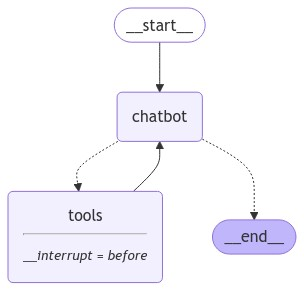

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Проверьте текущее состояние, как и раньше, чтобы подтвердить, что контрольная точка отражает наши ручные обновления.

In [24]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[HumanMessage(content='Я изучаю LangGraph. Не могла бы ты рассказать мне об этом подробней, из интернета?', id='d082cd49-cc03-4a67-aed8-8bcd53aafc46')]
('chatbot',)


**Обратите внимание**: что мы продолжаем добавлять сообщения AIMessage в state. Поскольку мы действуем как `chatbot` и отвечаем сообщением AIMessage, которое не содержит `tool_calls`, граф знает, что он вошел в завершенное состояние (`next` пуст).

#### Что делать, если вы хотите **перезаписать** существующие сообщения?

Функция [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages), которую мы использовали для аннотирования состояния графа выше, контролирует, как обновляются сообщения. Эта функция проверяет любые идентификаторы сообщений в новом списке `messages`. Если ID совпадает с сообщением в существующем состоянии, [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) перезаписывает существующее сообщение новым содержимым.

В качестве примера давайте обновим вызов инструмента, чтобы убедиться, что мы получаем хорошие результаты от нашего поисковика! Сначала начните новый поток:

In [25]:
user_input = "Я изучаю LangGraph. Не могла бы ты рассказать мне об этом подробней, из интернета?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Я изучаю LangGraph. Не могла бы ты рассказать мне об этом подробней, из интернета?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (6f255f89-dd5f-4d31-bdfa-5b6108168c0e)
 Call ID: 6f255f89-dd5f-4d31-bdfa-5b6108168c0e
  Args:
    query: LangGraph


**Далее**, давайте обновим вызов инструмента для нашего агента. Возможно, мы хотим найти конкретные практические кейсы с использованием подхода human-in-the-loop.

In [26]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-5842a2e4-aa03-497b-9d7a-f3b31f7f2c25-0
{'name': 'duckduckgo_search', 'args': {'query': 'LangGraph'}, 'id': '6f255f89-dd5f-4d31-bdfa-5b6108168c0e', 'type': 'tool_call'}
Updated
{'name': 'duckduckgo_search', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': '6f255f89-dd5f-4d31-bdfa-5b6108168c0e', 'type': 'tool_call'}
Message ID run-5842a2e4-aa03-497b-9d7a-f3b31f7f2c25-0


Tool calls


[{'name': 'duckduckgo_search',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': '6f255f89-dd5f-4d31-bdfa-5b6108168c0e',
  'type': 'tool_call'}]

**Обратите внимание**, что мы изменили вызов инструмента ИИ, чтобы искать "LangGraph human-in-the-loop workflow" вместо простого "LangGraph".

Ознакомьтесь с [трассировкой LangSmith](https://smith.langchain.com/public/cd7c09a6-758d-41d4-8de1-64ab838b2338/r), чтобы увидеть вызов обновления состояния — вы можете увидеть, что наше новое сообщение успешно обновило предыдущее сообщение ИИ.

Возобновите граф, передавая входные данные `None` и существующую конфигурацию.

In [27]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (6f255f89-dd5f-4d31-bdfa-5b6108168c0e)
 Call ID: 6f255f89-dd5f-4d31-bdfa-5b6108168c0e
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: duckduckgo_search

In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an... TD;LR Key Takeaways : Human in the Loop (HITL) is crucial for maintaining AI accuracy and preventing errors. LangGraph.js is a tool designed to implement HITL in AI workflows. Whether through interrupts or the strategic management of persistence, humans ensure that AI systems remain flexible, ethical, and responsive to real-world needs. By leveraging LangGraph's persistence features, developers can create AI systems that perform optimally and maintain a balance between auto

Ознакомьтесь с [trace](https://smith.langchain.com/public/2d633326-14ad-4248-a391-2757d01851c4/r/6464f2f2-edb4-4ef3-8f48-ee4e249f2ad0), чтобы увидеть вызов инструмента и последующий ответ LLM. **Обратите внимание**, что теперь граф запрашивает поисковую систему, используя наш обновленный термин запроса — мы смогли вручную переопределить поиск LLM здесь!

Все это отражено в контрольной точке памяти графа, что означает, что если мы продолжим разговор, он вспомнит все _измененное_ состояние.

In [28]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Напомни, что я изучаю?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Напомни, что я изучаю?
================================== Ai Message ==================================

Вы изучаете LangGraph.


**Поздравляем!** Вы использовали `interrupt_before` и `update_state`, чтобы вручную изменять состояние как часть human-in-the-loop. Прерывания и модификации состояния позволяют вам контролировать, как ведет себя агент. В сочетании с постоянным созданием контрольных точек это означает, что вы можете `приостановить` действие и `возобновить` его в любой момент.

Код графа для этого раздела идентичен предыдущим. Ключевые фрагменты, которые нужно запомнить, — это добавить `.compile(..., interrupt_before=[...])` (или `interrupt_after`), если вы хотите явно приостановить граф всякий раз, когда он достигает узла. Затем вы можете использовать `update_state`, чтобы изменить контрольную точку и контролировать, как граф должен продолжить работу.

## Часть 6: Кастомный `State`

До сих пор мы полагались на простое `State` (это просто список сообщений!). Вы можете продвинуться далеко с этим простым `State`, но если вы хотите определить сложное поведение, не полагаясь на список сообщений, вы можете добавить дополнительные поля в `State`. В этом разделе мы расширим нашего чат-бота новым узлом, чтобы проиллюстрировать это.

В примерах выше мы включали человека детерминированно: граф __всегда__ прерывался, когда вызывался инструмент. Предположим, мы хотим, чтобы наш чат-бот имел возможность полагаться на человека.

Один из способов сделать это — создать проходной узел "human", перед которым граф всегда будет останавливаться. Мы будем выполнять этот узел только в том случае, если LLM вызовет инструмент "human". Для удобства мы добавим флаг "ask_human" в состояние нашего графа, который будет равен 1,  если LLM захочет вызвать этот инструмент.

Ниже определите этот новый граф с обновленным `State`.

In [33]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

Далее определите схему, чтобы показать модели, чтобы она могла решить запросить помощь.

In [34]:
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel

class RequestAssistance(BaseModel):
    """
    Переведите разговор на уровень эксперта. Используйте это, если вы не можете помочь напрямую или если пользователю требуется помощь эксперта, выходящая за рамки ваших разрешений.
    Чтобы использовать эту функцию, передайте запрос пользователя, чтобы эксперт мог предоставить правильные рекомендации.
    """

    request: str

Далее определите узел чат-бота. Основное изменение здесь — включить флаг `ask_human`, если мы увидим, что чат-бот вызвал флаг `RequestAssistance`.

In [35]:
from typing import Annotated

from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from dotenv import load_dotenv
from pathlib import Path
from langchain.chat_models.gigachat import GigaChat
import os
from langchain_community.tools import DuckDuckGoSearchRun

graph_builder = StateGraph(State)


tdotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)


GC_CREDS = os.getenv('GC_CREDS')
GC_SCOPE = os.getenv('GC_SCOPE')

llm = GigaChat(
    credentials=GC_CREDS,
    scope=GC_SCOPE,
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    timeout=1200
    )

tool = DuckDuckGoSearchRun(max_results=2)
tools = [tool]


llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

Далее создадим `graph builder` и добавим узлы чат-бота и инструментов в граф, как и раньше.

In [36]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

Далее создайте узел "human". Эта функциональная `node` в нашем графе вызовет прерывание. Если человек __не__ обновит состояние во время `interrupt`, он вставит сообщение "От эксперта нет ответа.", чтобы LLM знал, что пользователь был запрошен, но не ответил. Этот узел также снимает флаг `ask_human`, чтобы граф знал, что не нужно возвращаться к этому узлу, если дальнейшие запросы не будут сделаны.

In [37]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("От эксперта нет ответа.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

Далее определите условную логику. Функция `select_next_node` направит к узлу `human`, если флаг установлен. В противном случае она позволит предустановленной функции `tools_condition` выбрать следующий узел.

Напомним, что функция `tools_condition` просто проверяет, ответил ли `chatbot` какими-либо `tool_calls` в своем ответном сообщении. Если да, она направляет к узлу `action`. В противном случае она завершает граф.

In [38]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

Наконец, добавьте простые направленные ребра и скомпилируйте граф. Эти ребра инструктируют граф **всегда** переходить от узла `a` к узлу `b`, когда `a` завершает выполнение.

In [39]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

Если у вас установлены зависимости визуализации, вы можете увидеть структуру графа ниже

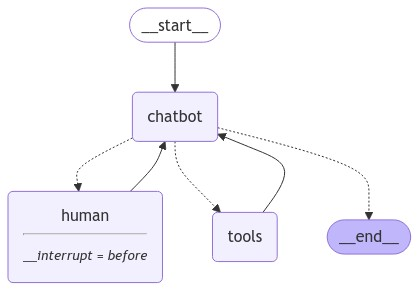

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Чат-бот может либо запросить помощь от человека (chatbot->select->human), вызвать инструмент поисковой системы (chatbot->select->action), либо напрямую ответить (chatbot->select->__end__). Как только действие или запрос будет сделан, граф перейдет обратно к узлу `chatbot`, чтобы продолжить операции.

Давайте посмотрим, как этот граф работает на практике. Мы запросим помощь эксперта, чтобы проиллюстрировать наш граф.

In [43]:
user_input = "Мне нужно экспертное знание для создания этого агента ИИ. Не могли бы вы запросить помощь у эксперта для меня?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Мне нужно экспертное знание для создания этого агента ИИ. Не могли бы вы запросить помощь у эксперта для меня?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (bb7bd0b0-28d1-4b3f-940d-52cd1a150feb)
 Call ID: bb7bd0b0-28d1-4b3f-940d-52cd1a150feb
  Args:
    request: Мне нужно экспертное знание для создания этого агента ИИ. Не могли бы вы запросить помощь у эксперта для меня?


**Обратите внимание:** LLM вызвал инструмент "`RequestAssistance`", который мы ему предоставили, и прерывание было установлено. Давайте проверим состояние графа, чтобы подтвердить.

In [44]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

Состояние графа действительно **прервано** перед узлом `'human'`. Мы можем выступить в роли "эксперта" в этом сценарии и вручную обновить состояние, добавив новое сообщение ToolMessage с нашим вводом.

Далее ответьте на запрос чат-бота, выполнив следующие действия:
1. Создайте `ToolMessage` с нашим ответом. Это будет передано обратно в `chatbot`.
2. Вызовите `update_state`, чтобы вручную обновить состояние графа.

In [45]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "Мы, эксперты, здесь, чтобы помочь! "
    "Мы рекомендуем вам ознакомиться с LangGraph для создания вашего агента."
    "Тогда агенты получиться гораздо надежнее и более гибкими, чем простые автономные агенты"
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7a671-048a-6d18-8005-f9301ff04e24'}}

Вы можете проверить состояние, чтобы подтвердить, что наш ответ был добавлен.

In [46]:
graph.get_state(config).values["messages"]

[HumanMessage(content='Мне нужно экспертное знание для создания этого агента ИИ. Не могли бы вы запросить помощь у эксперта для меня?', id='5abea506-89d7-4e73-ad4c-b9019995b261'),
 AIMessage(content='Конечно, я могу помочь вам с этим. Пожалуйста, предоставьте мне подробности о том, какие именно знания или навыки вам нужны, и я запрошу помощь у эксперта от вашего имени.', additional_kwargs={'functions_state_id': '2855dd22-0a03-4733-8128-41a3e233edf9'}, response_metadata={'token_usage': Usage(prompt_tokens=193, completion_tokens=47, total_tokens=240), 'model_name': 'GigaChat-Pro:1.0.26.8', 'finish_reason': 'stop'}, id='run-e540ce2f-030f-4e04-8931-53075638e941-0'),
 HumanMessage(content='Мне нужно экспертное знание для создания этого агента ИИ. Не могли бы вы запросить помощь у эксперта для меня?', id='8d10fbe5-515f-4b38-9c84-55aa729f135f'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': {'request': 'Мне нужно экспертное знание для со

Далее **возобновите** граф, вызвав его с `None` в качестве входных данных.

In [49]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Эксперты рекомендуют использовать LangGraph для создания вашего агента ИИ. Это поможет сделать его более надежным и гибким.


**Обратите внимание**, что чат-бот включил обновленное состояние в свой окончательный ответ. Поскольку **все** было создано в контрольных точках, "эксперт" в петле мог выполнить обновление в любое время, не влияя на выполнение графа.

**Поздравляем!** Теперь вы добавили дополнительный узел в граф помощника, чтобы позволить чат-боту решать самостоятельно, нужно ли прерывать выполнение. Вы сделали это, обновив состояние графа новым полем `ask_human` и изменив логику прерывания при компиляции графа. Это позволяет вам динамически включать человека в петлю, сохраняя полную **память** каждый раз, когда вы выполняете граф.

Мы почти закончили с учебником, но есть еще одна концепция, которую мы хотели бы рассмотреть перед завершением, которая связывает `checkpointing` и `state updates`.

Код этого раздела воспроизведен ниже для вашего ознакомления.

<details>
<summary>Полный код</summary>
<pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)
```
</pre>
</details>

## Часть 7: Путешествие во времени

В типичном рабочем процессе чат-бота пользователь взаимодействует с ботом один или несколько раз, чтобы выполнить задачу. В предыдущих разделах мы увидели, как добавить память и участие пользователя в цикл, чтобы иметь возможность создавать контрольные точки состояния графа и вручную переопределять состояние для управления будущими ответами.

Но что, если вы хотите позволить пользователю начать с предыдущего ответа и "ответвиться", чтобы исследовать отдельный исход? Или что, если вы хотите, чтобы пользователи могли "откатить" работу вашего помощника, чтобы исправить ошибки или попробовать другую стратегию?

Вы можете создать оба этих опыта и многое другое, используя встроенную функцию "time travel" LangGraph.

В этом разделе вы "откатите" свой граф, извлекая контрольную точку с помощью метода `get_state_history` графа. Затем вы сможете возобновить выполнение с этой предыдущей точки времени.

Сначала вспомните наш граф чат-бота. Нам не нужно делать **никаких** изменений по сравнению с предыдущим:

In [2]:
from typing import Annotated, Literal
from pydantic import BaseModel
from langchain_core.messages import AIMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from dotenv import load_dotenv
from pathlib import Path
from langchain.chat_models.gigachat import GigaChat
import os
from langchain_community.tools import DuckDuckGoSearchRun


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)


GC_CREDS = os.getenv('GC_CREDS')
GC_SCOPE = os.getenv('GC_SCOPE')

llm = GigaChat(
    credentials=GC_CREDS,
    scope=GC_SCOPE,
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    timeout=1200
    )

tool = DuckDuckGoSearchRun(max_results=2)
tools = [tool]


llm_with_tools = llm.bind_tools(tools + [RequestAssistance])



def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

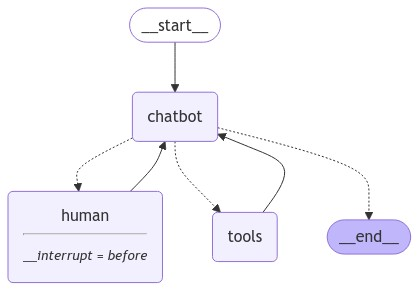

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Давайте заставим наш граф сделать пару шагов. Каждый шаг будет сохранен в истории состояний:

In [4]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "Я изучаю LangGraph. Не могла бы ты рассказать мне об этом подробней, из интернета?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Я изучаю LangGraph. Не могла бы ты рассказать мне об этом подробней, из интернета?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (0c64249b-17c3-493b-89c4-69f2992bc70e)
 Call ID: 0c64249b-17c3-493b-89c4-69f2992bc70e
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: duckduckgo_search

LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management. LangGraph doesn't enforce best practices like CrewAI does (for example, role-playing or guardrails). So it can lead to poorer results. I would say that CrewAI is a better framework for newbies and common use cases because it helps 

In [5]:
events = graph.stream(
    {
        "messages": [
            ("user", "Да, это полезно. Может, я создам с его помощью автономного агента!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Да, это полезно. Может, я создам с его помощью автономного агента!
================================== Ai Message ==================================

Звучит интересно! Создание автономного агента может быть сложной, но увлекательной задачей. Если у вас возникнут вопросы в процессе работы, не стесняйтесь обращаться за дополнительной информацией.


Теперь, когда агент сделал пару шагов, мы можем `воспроизвести` полную историю состояний, чтобы увидеть все, что произошло.

In [9]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  7 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-------------------------------------

In [7]:
print(state)

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef7b300-eb9a-67f8-bfff-ca607a6e6d19'}}, metadata={'source': 'input', 'writes': {'__start__': {'messages': [['user', 'Я изучаю LangGraph. Не могла бы ты рассказать мне об этом подробней, из интернета?']]}}, 'step': -1, 'parents': {}}, created_at='2024-09-25T11:19:40.746951+00:00', parent_config=None, tasks=(PregelTask(id='9a82ed0c-61ff-b2fe-4058-6b3b85defc4a', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None),))


**Обратите внимание**, что контрольные точки сохраняются для каждого шага графа. Это __вызовы__, вы можете откатиться через всю историю потока. Мы выбрали `to_replay` как состояние для возобновления. Это состояние после узла `chatbot` во втором вызове графа выше.

Возобновление с этой точки должно вызвать узел **action** далее.

In [202]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef775ca-b326-699e-8006-8ca7ec9b9ad3'}}


**Обратите внимание**, что конфигурация контрольной точки (`to_replay.config`) содержит **метку времени** `thread_ts`. Предоставление этого значения `thread_ts` говорит контрольной точке LangGraph **загрузить** состояние с этого момента времени. Давайте попробуем это ниже:

In [205]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Звучит интересно! LangGraph действительно может помочь в создании сложных и многоагентных систем. Если у вас есть конкретные вопросы о том, как начать работу с этим инструментом или какие возможности он предоставляет, я с удовольствием помогу вам разобраться.


Обратите внимание, что граф возобновил выполнение с узла `**action**`. Вы можете сказать, что это так, поскольку первое значение, напечатанное выше, является ответом от нашего инструмента поисковой системы.

**Поздравляем!** Теперь вы использовали обход контрольных точек путешествия во времени в LangGraph. Возможность откатиться и исследовать альтернативные пути открывает мир возможностей для отладки, экспериментов и интерактивных приложений.

## Заключение

Поздравляем! Вы завершили вводный учебник и создали чат-бота в LangGraph, который поддерживает вызов инструментов, постоянную память, интерактивность с человеком в петле и даже путешествие во времени!

[Документация LangGraph](https://langchain-ai.github.io/langgraph/) — отличный ресурс для более глубокого погружения в возможности библиотеки.